# Inference Time

In [ ]:
from dust3r.inference import inference, load_model
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

import time
import numpy as np

model_path = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
device = 'cuda:6'
batch_size = 1
schedule = 'cosine'
lr = 0.01
niter = 300

model = load_model(model_path, device)
# load_images can take a list of images or a directory
images = load_images(['croco/assets/Chateau1.png', 'croco/assets/Chateau2.png'], size=512)

In [ ]:
batch = []
for _ in range(100):
    times = []
    t0 = time.time()
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    t1 = time.time()
    times.append(t1 - t0)
    output, ts = inference(pairs, model, device, batch_size=batch_size, return_times=True)
    times += ts
    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']
    # here, view1, pred1, view2, pred2 are dicts of lists of len(2)
    #  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
    # in each view you have:
    # an integer image identifier: view1['idx'] and view2['idx']
    # the img: view1['img'] and view2['img']
    # the image shape: view1['true_shape'] and view2['true_shape']
    # an instance string output by the dataloader: view1['instance'] and view2['instance']
    # pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
    # pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
    # pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

    # next we'll use the global_aligner to align the predictions
    # depending on your task, you may be fine with the raw output and not need it
    # with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
    # if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment
    t0 = time.time()
    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    t1 = time.time()
    times.append(t1 - t0)
    loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

    # retrieve useful values from scene:
    imgs = scene.imgs
    t0 = time.time()
    focals = scene.get_focals()
    poses = scene.get_im_poses()
    pts3d = scene.get_pts3d()
    confidence_masks = scene.get_masks()
    t1 = time.time()
    times.append(t1 - t0)
    batch.append(times)

batch = np.array(batch)
print('Pairing, Encoder, Decoder, Downstream Head')
print(f'batch times: {batch.mean(0)}')
print(f'batch times std: {batch.std(0)}')
print(f'% of time spent in each step: {batch.mean(0) / batch.mean(0).sum() * 100}')

    Pairing         Encoder        Decoder        Head           Scene          Scene Parsing
    17.82us         19.93ms        26.93ms        11.24ms        72.59ms        6.69ms
    0.01%           14.51%         19.59%         8.18%          52.83%         4.87%

    Pairing         Encoder        Decoder        Head           Scene          Scene Parsing
    19.42us         16.71ms        23.73ms        14.48ms        20.95ms        6.98ms
    6.88us          2.81ms         2.23ms         2.51ms         9.37ms         1.19ms
    0.02%           20.17%         28.64%         17.48%         25.28%         8.42%

In [ ]:
0.01 + 14.51 + 19.59 + 8.18 + 52.83 + 4.87

In [ ]:
s = [16.71, 23.73, 14.48]
s = [19.93, 26.93, 11.24]

[i / sum(s) * 100 for i in s]

In [ ]:
sum(s)

# Pre-save Features

In [ ]:
from PIL import Image

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000001.jpg')

In [ ]:
import json

with open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/selected_seqs_train.json') as f:
    train = json.load(f)
with open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/selected_seqs_test.json') as f:
    test = json.load(f)

In [ ]:
train

In [ ]:
test

In [ ]:
[(i, train[i].keys()) for i in train.keys()]

In [ ]:
from jsondiff import diff
diff(train, test)

In [ ]:
import glob

list_1 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.jpg")
list_2 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.npy")
list_3 = glob.glob(r"/ssd1/sa58728/dust3r/data/co3d_subset_processed/*/*/images/*.npz")
len(list_1), len(list_2), len(list_3)

In [ ]:
list_1 = [f[:-4] for f in list_1]
list_2 = [f[:-4] for f in list_2]
list_3 = [f[:-4] for f in list_3]

In [ ]:
s = set(list_2)
temp = [x for x in list_1 if x not in s]
print(sorted(temp))
len(temp)

In [ ]:
list_1 == list_2, list_1 == list_3, list_2 == list_3

In [ ]:
list_2


In [ ]:
import os

for i in list_2:
    os.remove(i)
    continue

In [ ]:
import torch
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model

model = AsymmetricCroCo3DStereo(
    pos_embed='RoPE100',
    img_size=(224, 224),
    head_type='linear',
    output_mode='pts3d', 
    depth_mode=('exp', -inf, inf), 
    conf_mode=('exp', 1, inf), 
    enc_embed_dim=192, 
    enc_depth=12, 
    enc_num_heads=3, 
    dec_embed_dim=768, 
    dec_depth=12, 
    dec_num_heads=12)

In [ ]:
train_modules = [model.patch_embed, model.mask_generator, model.rope, model.enc_blocks, model.enc_norm]
train_params = torch.nn.ParameterList([p for m in train_modules for p in m.parameters()])

In [ ]:
opt = torch.optim.Adam(train_params, lr=1e-3)

# Build Model

In [ ]:
import torch
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.inference import load_model

In [ ]:
MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"
MODEL_NEW = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"

CKPT = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
CKPT_KD = "log/train_10/checkpoint-best.pth"
CKPT_NEW = "checkpoints/DUSt3R_ViTSmall_BaseDecoder_512_dpt_kd.pth"

In [ ]:
model = load_model(CKPT, 'cpu')

In [ ]:
model_kd = eval(MODEL_KD)
ckpt_kd = torch.load(CKPT_KD)['model']
print(model_kd.load_state_dict(ckpt_kd, strict=True))

In [ ]:
model_new = eval(MODEL_NEW)

In [ ]:
module_list = ['decoder_embed', 'dec_norm', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
module_list_kd = ['patch_embed', 'mask_generator', 'rope', 'enc_blocks', 'enc_norm', 'adapter']

In [ ]:
for m in module_list:
    getattr(model_new, m).load_state_dict(getattr(model, m).state_dict(), strict=True)
model_new.mask_token = model.mask_token

for m in module_list_kd:
    getattr(model_new, m).load_state_dict(getattr(model_kd, m).state_dict(), strict=True)

In [ ]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismatch found at', key_item_1[0], key_item_2[0])
            else:
                print('Error at', key_item_1[0], key_item_2[0])
            return False
    if models_differ == 0:
        # print('Models match perfectly! :)')
        return True

In [ ]:
for m, k in zip(model_kd.named_children(), model_new.named_children()):
    print(m[0], compare_models(m[1],k[1]), '\n')

In [ ]:
l = [x for x in model_new.named_children() if x[0] != 'adapter']
for m, k in zip(model.named_children(), l):
    print(m[0], compare_models(m[1],k[1]), '\n')
    # except:
    #     print(m[0], "Size Mismatch")

In [ ]:
torch.save(model_new.state_dict(), CKPT_NEW)

In [ ]:
ckpt_new = torch.load(CKPT_NEW)
print(model_kd.load_state_dict(ckpt_new, strict=False))

In [ ]:
def build_model_enc_dec(model_str, device):
    teacher = load_model("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", device)
    teacher.eval()

    model = eval(model_str)
    model.to(device)
    model.eval()

    module_list = ['decoder_embed', 'dec_norm', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
    for m in module_list:
        getattr(model, m).load_state_dict(getattr(teacher, m).state_dict(), strict=True)

    return teacher, model

In [ ]:
teacher, model = build_model_enc_dec(MODEL_NEW, 'cpu')

In [ ]:
l = [x for x in model.named_children() if x[0] != 'adapter']
for m, k in zip(teacher.named_children(), l):
    print(m[0], compare_models(m[1],k[1]), '\n')

In [ ]:
from PIL import Image

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000060.jpg')

In [ ]:
Image.open('/ssd1/sa58728/dust3r/data/co3d_subset_processed/apple/110_13051_23361/images/frame000030.jpg')

In [ ]:
import torch

In [ ]:
w0 = torch.load('log/train_w_0/checkpoint-1.pth', map_location='cpu')['model']
w1 = torch.load('log/train_x_1/checkpoint-2.pth', map_location='cpu')['model']
w2 = torch.load('checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth', map_location='cpu')['model']

In [ ]:
h0 = torch.load('log_kd/log_h/ckpt/iter_2475.pth', map_location='cpu')
h1 = torch.load('log_kd/log_h/ckpt/iter_4950.pth', map_location='cpu')

In [ ]:
for i, j in zip(w2.items(), w0.items()):
    if torch.equal(i[1], j[1]):
        print(i[0], torch.equal(i[1], j[1]))

In [ ]:
w0['model']['mask_token']

In [ ]:
import torch
w = torch.load('log/train_10/checkpoint-last.pth')

In [ ]:
w.keys()

In [ ]:
w['best_so_far']

# Habitat MP3D

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import cv2, numpy as np
import matplotlib.pyplot as plt

# i = cv2.imread('/ssd1/wenyan/scannetpp_processed/d6d9ddb03f/depths/DSC05114.png')
i = cv2.imread('/mnt/wenyan/scannetpp_processed/d6d9ddb03f/depths/DSC05114.png')
i = i * 255.0 / i.max()
plt.imshow(i / 255.0, cmap='inferno')

In [ ]:
i.min(), i.max()

# ScanNet++ Splits

In [ ]:
import json
import os

In [ ]:
BASE_PATH = '/ssd1/wenyan/scannetpp_processed'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    frames = os.listdir(os.path.join(base_path, scene, 'images'))
    return [int(f.split('.')[0].split("DSC")[1].lstrip("0")) for f in frames if f.endswith('.JPG')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [ ]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [ ]:
from dust3r.datasets import ScanNet

dataset = ScanNet(split='train', ROOT='/ssd1/wenyan/scannetpp_processed', aug_crop=16, mask_bg='rand', resolution=224)

In [ ]:
for i in dataset:
    print(i)
    break

# DL3DV Splits

In [ ]:
import json
import os

In [ ]:
BASE_PATH = '/ssd1/sa58728/dust3r/data/DL3DV-10K/'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    frames = os.listdir(os.path.join(base_path, scene, 'gaussian_splat/images_4'))
    return [int(f.split('.')[0].split("frame_")[1].lstrip("0")) for f in frames if f.endswith('.png')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [ ]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [ ]:
from dust3r.datasets import DL3DV

dataset = DL3DV(split='train', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', aug_crop=16, mask_bg='rand', resolution=224)

for i in dataset:
    print(i[0]['img'].shape)
    break

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(i[0]['img'][0])

# MegaDepth Splits

In [ ]:
import json
import os

In [ ]:
BASE_PATH = '/ssd1/sa58728/dust3r/data/MegaDepth_v1/'

def split_train_test(scenes, split=0.8):
    n = len(scenes)
    train = scenes[:int(n * split)]
    test = scenes[int(n * split):]
    return train, test

def get_scene_frames(scene, base_path):
    if scene.endswith('list'):
        return []
    try:
        frames = os.listdir(os.path.join(base_path, scene, 'dense0/imgs/'))
    except:
        frames = os.listdir(os.path.join(base_path, scene, 'dense1/imgs/'))
    return [f.split('.')[0] for f in frames if f.endswith('.jpg')]


def get_split_scenes(split):
    scenes = {}
    for scene in split:
        if os.path.isdir(os.path.join(BASE_PATH, scene)):
            frames = get_scene_frames(scene, BASE_PATH)
            scenes[scene] = frames
    return scenes

In [ ]:
scenes = os.listdir(BASE_PATH)
train, test = split_train_test(scenes)
train = get_split_scenes(train)
test = get_split_scenes(test)

with open('selected_seqs_train.json', 'w') as file:
    json.dump(train, file)
with open('selected_seqs_test.json', 'w') as file:
    json.dump(test, file)

In [ ]:
from dust3r.datasets import MegaDepth

dataset = MegaDepth(split='train', ROOT='/ssd1/sa58728/dust3r/data/MegaDepth_v1', aug_crop=16, mask_bg='rand', resolution=224)

for i in dataset:
    print(i[0]['img'].shape)
    break

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(i[0]['img'][0])

# Gaussian Frames

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [ ]:
MEAN = 3
STD = 3

m, n = [], []
for i in range(100000):
    m.append(int(rng.normal(loc=0.0, scale=STD)) + MEAN)
    n.append(int(rng.normal(loc=0.0, scale=STD)))
o = [m - n for m, n in zip(m, n)] + [n - m for m, n in zip(m, n)]

In [ ]:
# v2
bins = plt.hist(o, bins=range(-24,30), align='left', density=True, cumulative=False)
# plt.xticks(np.arange(-21, 22, 3))
# plt.yticks(np.arange(0, 1.1, 0.05))
# plt.grid(True, alpha=0.3)
# plt.hlines(0.025, -20, 22, color='r', alpha=0.5)
# plt.hlines(0.975, -20, 22, color='r', alpha=0.5)
# plt.hlines(0.25, -20, 22, color='r', alpha=0.5)
# plt.hlines(0.75, -20, 22, color='r', alpha=0.5)
# plt.vlines(-9, 0, 1, color='r', alpha=0.5)
# plt.vlines(-3, 0, 1, color='r', alpha=0.5)
# plt.vlines(3, 0, 1, color='r', alpha=0.5)
# plt.vlines(9, 0, 1, color='r', alpha=0.5)
# plt.show()

In [ ]:
# v1
bins = plt.hist(o, bins=range(-24,30), align='left', density=True, cumulative=True)
plt.xticks(np.arange(-20, 22, 5))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, alpha=0.3)
plt.hlines(0.025, -20, 22, color='r', alpha=0.5)
plt.hlines(0.975, -20, 22, color='r', alpha=0.5)
plt.hlines(0.25, -20, 22, color='r', alpha=0.5)
plt.hlines(0.75, -20, 22, color='r', alpha=0.5)
plt.vlines(-15, 0, 1, color='r', alpha=0.5)
plt.vlines(-5, 0, 1, color='r', alpha=0.5)
plt.vlines(15, 0, 1, color='r', alpha=0.5)
plt.vlines(5, 0, 1, color='r', alpha=0.5)


In [ ]:
bins

In [ ]:
import itertools

combinations = [
    (i, j)
    for i, j in itertools.combinations(range(1000), 2)
    if 0 < abs(i-j) <= 30 and abs(i-j) % 5 == 0
]
o = []
for i, j in combinations:
    imgs_idxs = [max(0, min(im_idx + rng.integers(-4, 5), 1000)) for im_idx in [i, j]]
    o.append(imgs_idxs[0] - imgs_idxs[1])
    o.append(imgs_idxs[1] - imgs_idxs[0])

In [ ]:
bins = plt.hist(o, bins=range(-40,40), align='left', density=True, cumulative=True)
plt.xticks(np.arange(-40, 40, 5))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, alpha=0.3)
plt.hlines(0.025, -40, 40, color='r', alpha=0.5)
plt.hlines(0.975, -40, 40, color='r', alpha=0.5)
plt.hlines(0.25, -40, 40, color='r', alpha=0.5)
plt.hlines(0.75, -40, 40, color='r', alpha=0.5)
plt.vlines(-32, 0, 1, color='r', alpha=0.5)
plt.vlines(-18, 0, 1, color='r', alpha=0.5)
plt.vlines(18, 0, 1, color='r', alpha=0.5)
plt.vlines(32, 0, 1, color='r', alpha=0.5)

# Save Pair Samples

In [ ]:
import os
from dust3r.datasets import get_data_loader  # noqa
from torchvision.utils import save_image

OUT_FOLDER = "pairs"
DATASET = "DL3DV"
GAUSSIAN = True

if DATASET == "Co3D":
    TRAIN_DATA = f"1000 @ Co3d(split='train', ROOT='/ssd1/wenyan/co3d_2_cat_processed', aug_crop=16, mask_bg='rand', resolution=224, transform=ImgNorm, gaussian_frames={GAUSSIAN})"
elif DATASET == "ScanNet":
    TRAIN_DATA = f"1000 @ ScanNet(split='train', ROOT='/ssd1/wenyan/scannetpp_processed', aug_crop=16, mask_bg='rand', resolution=224, transform=ImgNorm, gaussian_frames={GAUSSIAN})"
elif DATASET == "DL3DV":
    TRAIN_DATA = f"1000 @ DL3DV(split='train', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', aug_crop=16, mask_bg='rand', resolution=224, transform=ImgNorm, gaussian_frames={GAUSSIAN})"

loader = get_data_loader(
    TRAIN_DATA,
    batch_size=1,
    num_workers=4,
    pin_mem=True,
    shuffle=True,
    drop_last=True
)

if hasattr(loader, 'dataset') and hasattr(loader.dataset, 'set_epoch'):
    loader.dataset.set_epoch(0)
if hasattr(loader, 'sampler') and hasattr(loader.sampler, 'set_epoch'):
    loader.sampler.set_epoch(0)

In [ ]:
def save_image_pair(pair, plot=False):
    name1 = pair[0]['instance'][0].split('.')[0]
    name2 = pair[1]['instance'][0].split('.')[0]
    name = f"{name1}_{name2}"
    os.makedirs(f"{OUT_FOLDER}/{DATASET}/{name}", exist_ok=True)

    img1 = ((pair[0]['img'][0] * 0.5) + 0.5)
    img2 = ((pair[1]['img'][0] * 0.5) + 0.5)

    save_image(img1, f"{OUT_FOLDER}/{DATASET}/{name}/{name1}.png")
    save_image(img2, f"{OUT_FOLDER}/{DATASET}/{name}/{name2}.png")

    if plot:
        plt.imshow(img1.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

        plt.imshow(img2.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

In [ ]:
for i, pair in enumerate(loader, 1):
    save_image_pair(pair)
    if i == 100:
        break

# RoMa

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
# RoMa
import torch.nn.functional as F
from RoMa.roma.utils.utils import tensor_to_pil
from RoMa.roma import roma_outdoor
# DUSt3R
torch.backends.cuda.matmul.allow_tf32 = True  # for gpu >= Ampere and pytorch >= 1.12
from dust3r.losses import *  # noqa: F401, needed when loading the model
from dust3r.inference import loss_of_one_batch, load_model
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.utils.device import to_cpu, collate_with_cat
from test_pairs import *

CKPT = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"
CKPT_KD = "log/train_2/checkpoint-best.pth"
TEST_CRITERION = "ConfLoss(Regr3D(L21, norm_mode='avg_dis', kd=True), alpha=0.2) + Regr3D_ScaleShiftInv(L21, gt_scale=True, kd=True)"

device = torch.device('cpu')
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
img_path = "test/RoMa/"
im1_path = img_path + "DSC00410.png"
im2_path = img_path + "DSC09985.png"
save_path = "./roma.jpg"

In [ ]:
# Create model
roma_model = roma_outdoor(device=device, coarse_res=224, upsample_res=224)
H, W = roma_model.get_output_resolution()

im1 = Image.open(im1_path).resize((W, H))
im2 = Image.open(im2_path).resize((W, H))

teacher, model = load_pretrained(MODEL_KD, CKPT, CKPT_KD, device)
test_criterion = eval(TEST_CRITERION).to(device)

In [ ]:
images = load_images(img_path, size=224)
pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=False)

with torch.no_grad():
    result = loss_of_one_batch(collate_with_cat(pairs), teacher, test_criterion, device,
                            symmetrize_batch=False, features=True,
                            kd=True, kd_out=True, teacher=teacher, lmd=10)
    
result = to_cpu(result)
loss_value, loss_details = result['loss']  # criterion returns two values
loss_details['loss'] = loss_value.item()
print(f"Details: {loss_details}")

In [ ]:
result['pred1']['pts3d'].shape, result['pred2']['pts3d_in_other_view'].shape

In [ ]:
# Match
warp, certainty = roma_model.match(im1_path, im2_path, device=device)
warp, certainty = warp.reshape(-1, 2*H*W, 4), certainty.reshape(-1, 2*H*W)
warp_filter = warp[certainty > 0.55]
# out, valid = roma_model.sample(warp, certainty)
kptsA, kptsB = roma_model.to_pixel_coordinates(warp_filter, H, W, H, W)
kptsA, kptsB = kptsA.cpu().numpy().astype('int'), kptsB.cpu().numpy().astype('int')

In [ ]:
warp_filter.shape

In [ ]:
plt.imshow(certainty.reshape(H,2*W).cpu().numpy()>0.5, cmap='inferno')

In [ ]:
plt.hist(certainty.cpu().numpy().flatten(), cumulative=True, bins=100)
plt.hlines(90000, 0, 1, color='r', alpha=0.5)
plt.vlines(0.55, 0, 100000, color='r', alpha=0.5)

In [ ]:
warp.min(), warp.max()

In [ ]:
kptsA, kptsB = roma_model.to_pixel_coordinates(warp, H, W, H, W)

In [ ]:
kptsA.shape

In [ ]:
# Sampling not needed, but can be done with model.sample(warp, certainty)
x1 = (torch.tensor(np.array(im1)) / 255).to(device).permute(2, 0, 1)
x2 = (torch.tensor(np.array(im2)) / 255).to(device).permute(2, 0, 1)

# take only the matching part from images and copy colors (xyz values once normalized)
im1_transfer_rgb = F.grid_sample(
    x1[None], warp[:, W:, :2][None], mode="bilinear", align_corners=False
)[0]
im2_transfer_rgb = F.grid_sample(
    x2[None], warp[:,:W, 2:][None], mode="bilinear", align_corners=False
)[0]
warp_im = torch.cat((im2_transfer_rgb,im1_transfer_rgb),dim=2)
white_im = torch.ones((H,2*W),device=device)
vis_im = certainty * warp_im + (1 - certainty) * white_im
tensor_to_pil(vis_im, unnormalize=False).save(save_path)

In [ ]:
kptsB.shape

In [ ]:
i = 2500
print(kptsA[i])
plt.imshow(im1)
plt.scatter(*kptsA[i], c='r', s=10)
plt.show()
plt.imshow(im2)
plt.scatter(*kptsB[i], c='r', s=10)
plt.show()

In [ ]:
i = 1240
print(kptsA[i])
plt.imshow((pairs[0][1]['img'][0].permute(1, 2, 0)*0.5)+0.5)
plt.scatter(*kptsA[i], c='r', s=10)
plt.show()
plt.imshow((pairs[0][0]['img'][0].permute(1, 2, 0)*0.5)+0.5)
plt.scatter(*kptsB[i], c='r', s=10)
plt.show()
plt.imshow(result['pred2']['pts3d_in_other_view'][0,:,:,-1])
plt.scatter(*kptsA[i], c='r', s=10)
plt.show()
plt.imshow(result['pred1']['pts3d'][0,:,:,-1])
plt.scatter(*kptsB[i], c='r', s=10)
plt.show()

In [ ]:
result['pred1']['pts3d'][0,kptsB[:,0],kptsB[:,1]].shape


In [ ]:
p1 = result['pred1']['pts3d'][0,kptsB[:,0],kptsB[:,1]] # * valid[:,None].cpu()
p2 = result['pred2']['pts3d_in_other_view'][0,kptsA[:,0],kptsA[:,1]] # * valid[:,None].cpu()
print(p1.shape, p2.shape, (p1 - p2).abs().mean(), ((p1 - p2)**2).mean())

In [ ]:
kptsA[i].astype('int'), kptsA[i], kptsB[i].astype('int'), kptsB[i]

In [ ]:
result['pred1']['pts3d'].shape

# Batch RoMa

In [1]:
import matplotlib.pyplot as plt
from dust3r.inference import *
from test import *

H, W = 224, 224

In [2]:
import argparse
import numpy as np
import os
import random
from collections import defaultdict
from pathlib import Path
from typing import Sized
from copy import deepcopy
import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
torch.backends.cuda.matmul.allow_tf32 = True  # for gpu >= Ampere and pytorch >= 1.12

from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.datasets import get_data_loader  # noqa
from dust3r.losses import *  # noqa: F401, needed when loading the model
from dust3r.inference import loss_of_one_batch, load_model
import dust3r.utils.path_to_croco  # noqa: F401
import croco.utils.misc as misc  # noqa
from RoMa.roma import roma_outdoor

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

TEST_DATA = "Co3d(split='test', ROOT='/ssd1/sa58728/dust3r/data/co3d_subset_processed', resolution=224, seed=777, gaussian_frames=False)" # Unseen scenes
TEST_DATA += " + ScanNet(split='test', ROOT='/ssd1/wenyan/scannetpp_processed', resolution=224, seed=777, gaussian_frames=True)" # Unseen scenes
TEST_DATA += " + DL3DV(split='test', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', resolution=224, seed=777, gaussian_frames=True)" # Unseen scenes

MODEL_KD = "AsymmetricCroCo3DStereo(pos_embed='RoPE100', img_size=(224, 224), head_type='dpt', \
            output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), \
            enc_embed_dim=384, enc_depth=12, enc_num_heads=6, dec_embed_dim=768, dec_depth=12, dec_num_heads=12, adapter=True)"
CKPT = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
CKPT_KD = None # "checkpoints/DUSt3R_ViTSmall_BaseDecoder_512_dpt_kd.pth"
TEST_CRITERION = "ConfLoss(Regr3D(L21, norm_mode='avg_dis', kd=True), alpha=0.2) + Regr3D_ScaleShiftInv(L21, gt_scale=True, kd=True)"

def get_args_parser():
    parser = argparse.ArgumentParser('DUSt3R training', add_help=False)
    # model and criterion
    parser.add_argument('--model', default=MODEL_KD, type=str, help="string containing the model to build")
    parser.add_argument('--pretrained', default=None, help='path of a starting checkpoint') # CKPT_KD
    parser.add_argument('--test_criterion', default=TEST_CRITERION, type=str, help="test criterion")
    # dataset
    parser.add_argument('--test_dataset', default=TEST_DATA, type=str, help="testing set")
    parser.add_argument('--seed', default=777, type=int, help="Random seed")
    # others
    parser.add_argument('--num_workers', default=8, type=int)
    parser.add_argument('--world_size', default=1, type=int, help='number of distributed processes')
    parser.add_argument('--local_rank', default=0, type=int)
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')

    parser.add_argument('--eval_freq', type=int, default=1, help='Test loss evaluation frequency')
    parser.add_argument('--save_freq', default=1, type=int,
                        help='frequence (number of epochs) to save checkpoint in checkpoint-last.pth')
    parser.add_argument('--keep_freq', default=1, type=int,
                        help='frequence (number of epochs) to save checkpoint in checkpoint-%d.pth')
    parser.add_argument('--print_freq', default=1000, type=int,
                        help='frequence (number of iterations) to print infos while training')
    parser.add_argument('--teacher_path', default=CKPT, type=str, help="path to the teacher model")

    parser.add_argument('--lmd', default=10, type=float, help="kd loss weight")
    parser.add_argument('--output_dir', default='./log/train/', type=str, help="path where to save the output")
    parser.add_argument('--cuda', default=7, type=int, help="cuda device")
    parser.add_argument('--ckpt', default=None, type=str, help="resume from checkpoint") # "log/ckpt/iter_24750.pth"
    parser.add_argument('--batch_size', default=8, type=int, help="Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus")
    parser.add_argument('--accum_iter', default=1, type=int, help="Accumulate gradient iterations")
    parser.add_argument('--kd', default=True, type=bool)
    parser.add_argument('--kd_out', default=True, action='store_true', help="knowledge distillation (output)")

    return parser

def build_dataset(dataset, batch_size, num_workers, test=False):
    split = ['Train', 'Test'][test]
    print(f'Building {split} Data loader for dataset: ', dataset)
    loader = get_data_loader(dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             pin_mem=True,
                             shuffle=not (test),
                             drop_last=not (test))

    print(f"{split} dataset length: ", len(loader))
    return loader

def load_pretrained(args, device):
    teacher = load_model(args.teacher_path, device)
    teacher.eval()

    model = deepcopy(teacher)
    model.to(device)
    model.eval()

    model_kd = eval(args.model)
    model_kd.to(device)
    model_kd.eval()

    ckpt = torch.load(args.ckpt, map_location=device)
    try:
        print(model_kd.load_state_dict(ckpt['model'], strict=True))
        args.start_epoch = ckpt['epoch']
    except:
        print(model_kd.load_state_dict(ckpt, strict=True))
    del ckpt  # in case it occupies memory

    model.patch_embed = deepcopy(model_kd.patch_embed)
    model.mask_generator = deepcopy(model_kd.mask_generator)
    model.rope = deepcopy(model_kd.rope)
    model.enc_blocks = deepcopy(model_kd.enc_blocks)
    model.enc_norm = deepcopy(model_kd.enc_norm)
    model.adapter = deepcopy(model_kd.adapter)

    return teacher, model

def build_model_enc_dec(model_str, device, args):
    teacher = load_model("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", device)
    teacher.eval()

    if "x" in args.output_dir:
        print("Using pretrained Dust3R")
        model = load_model("checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth", device)
    else:
        print("Training from scratch")
        model = eval(model_str)

    model.to(device)
    if args.ckpt:
        ckpt = torch.load(args.ckpt)
        print(model.load_state_dict(ckpt['model'], strict=True))
        args.start_epoch = ckpt['epoch']
        model.train()

    module_list = ['decoder_embed', 'dec_blocks', 'dec_norm', 'dec_blocks2', 'downstream_head1', 'downstream_head2']
    for m in module_list:
        getattr(model, m).load_state_dict(getattr(teacher, m).state_dict(), strict=True)
        getattr(model, m).eval()
    model.mask_token = teacher.mask_token

    return teacher, model

xFormers not available
xFormers not available


In [3]:
args = get_args_parser()
args = args.parse_args('')

misc.init_distributed_mode(args)

device = f"cuda:6" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = False
cudnn.deterministic = True

data_loader_test = {dataset.split('(')[0]: build_dataset(dataset, args.batch_size, args.num_workers, test=True)
                    for dataset in args.test_dataset.split('+')}

# teacher, model = load_pretrained(args, device)
teacher, model = build_model_enc_dec(args.model, device, args)
roma_model = roma_outdoor(device=device, coarse_res=224, upsample_res=224)
test_criterion = eval(args.test_criterion or args.criterion).to(device)

Not using distributed mode
Building Test Data loader for dataset:  Co3d(split='test', ROOT='/ssd1/sa58728/dust3r/data/co3d_subset_processed', resolution=224, seed=777, gaussian_frames=False) 
Test dataset length:  2475
Building Test Data loader for dataset:   ScanNet(split='test', ROOT='/ssd1/wenyan/scannetpp_processed', resolution=224, seed=777, gaussian_frames=True) 
Test dataset length:  255
Building Test Data loader for dataset:   DL3DV(split='test', ROOT='/ssd1/sa58728/dust3r/data/DL3DV-10K', resolution=224, seed=777, gaussian_frames=True)
Test dataset length:  340
... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys

/home/sa58728/anaconda3/envs/dust3r/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sa58728/anaconda3/envs/dust3r/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (224, 224), and upsample res (224, 224)


In [4]:
def tensor_to_plot(tensor, norm=None):
    STD = np.array([0.229, 0.224, 0.225])
    MEAN = np.array([0.485, 0.456, 0.406])
    if norm == 'roma':
        return tensor.cpu().permute(1,2,0).numpy() * STD + MEAN
    elif norm == 'dust3r':
        return (tensor.cpu().permute(1,2,0).numpy() * 0.5) + 0.5
    return tensor.cpu().permute(1,2,0).numpy()

In [5]:
# def loss_of_one_batch(batch, model, criterion, device, symmetrize_batch=False, use_amp=False, ret=None, 
#                       return_times=False, features_only=False, features=False, 
#                       kd=False, kd_out=False, teacher=None, lmd=1, criterion_kd=torch.nn.MSELoss(),
#                       roma_model=None):
#     view1, view2 = batch
#     for view in batch:
#         for name in 'img pts3d valid_mask camera_pose camera_intrinsics F_matrix corres'.split():  # pseudo_focal
#             if name not in view:
#                 continue
#             view[name] = view[name].to(device, non_blocking=True)

#     with torch.cuda.amp.autocast(enabled=bool(use_amp)):
#         outs = model(view1, view2, return_times=return_times, features_only=features_only, features=features)
#         pred1, pred2 = outs

#     loss, loss_tot = 0, 0
#     loss_dict = {}

#     with torch.no_grad():
#         renorm_img1 = (view1['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)
#         renorm_img2 = (view2['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)
#         warp, certainty = roma_model.match(renorm_img1, renorm_img2, batched=True, device=device)
#         out, valid = roma_model.sample(warp, certainty) # THIS DOES NOT WORK WITH BATCHES
#         warp, certainty = warp.reshape(-1, 2*SIZE*SIZE, 4), certainty.reshape(-1, 2*SIZE*SIZE)
#         idxs = torch.topk(certainty, 1000, dim=-1).indices
#         certainty = certainty.gather(-1, idxs)
#         warp = warp.gather(-2, idxs.unsqueeze(-1).expand(-1, -1, 4))
#         kptsA, kptsB = roma_model.to_pixel_coordinates(warp, SIZE, SIZE, SIZE, SIZE)
#         kptsA, kptsB = kptsA.type(torch.int64), kptsB.type(torch.int64)

#     p1 = outs[0]['pts3d'].gather(1, kptsB.unsqueeze(-1).expand(-1, -1, -1, 3))
#     p2 = outs[1]['pts3d_in_other_view'].gather(1, kptsA.unsqueeze(-1).expand(-1, -1, -1, 3))

#     loss_dict['roma_mse'] = ((p1 - p2)**2).mean()
#     loss_dict['roma_mae'] = ((p1 - p2).abs()).mean()
#     loss_tot += loss_dict['roma_mse'] * lmd
#     loss = (loss_tot, loss_dict)

#     result = dict(view1=view1, view2=view2, pred1=pred1, pred2=pred2, loss=loss)
#     return result[ret] if ret else result

In [6]:
# @torch.no_grad()
# def test_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
#                    data_loader: Sized, device: torch.device, epoch: int,
#                    args, log_writer=None, prefix='test', 
#                    kd=False, teacher=None, features=False, curr_step=0,
#                    roma_model=None):
                    
#     model.eval()
#     metric_logger = misc.MetricLogger(delimiter="  ")
#     metric_logger.meters = defaultdict(lambda: misc.SmoothedValue(window_size=9**9))
#     header = 'Test Epoch: [{}]\n>'.format(epoch)

#     if hasattr(data_loader, 'dataset') and hasattr(data_loader.dataset, 'set_epoch'):
#         data_loader.dataset.set_epoch(epoch)
#     if hasattr(data_loader, 'sampler') and hasattr(data_loader.sampler, 'set_epoch'):
#         data_loader.sampler.set_epoch(epoch)

#     for _, batch in enumerate(metric_logger.log_every(data_loader, args.print_freq, header)):
        
#         loss_tuple = loss_of_one_batch(batch, model, criterion, device,
#                                        symmetrize_batch=True, features=features, ret='loss', 
#                                        kd=kd, kd_out=args.kd_out, teacher=teacher, lmd=args.lmd,
#                                        roma_model=roma_model)
#         return loss_tuple        

#     # gather the stats from all processes
#     metric_logger.synchronize_between_processes()
#     print("Averaged stats:", metric_logger)

#     aggs = [('avg', 'global_avg'), ('med', 'median')]
#     results = {f'{k}_{tag}': getattr(meter, attr) for k, meter in metric_logger.meters.items() for tag, attr in aggs}

#     return results

In [106]:
for test_name, testset in reversed(data_loader_test.items()):
    print(test_name)
    model.eval()
    metric_logger = misc.MetricLogger(delimiter="  ")
    metric_logger.meters = defaultdict(lambda: misc.SmoothedValue(window_size=9**9))
    header = 'Test Epoch: [{}]\n>'.format(0)

    if hasattr(testset, 'dataset') and hasattr(testset.dataset, 'set_epoch'):
        testset.dataset.set_epoch(0)
    if hasattr(testset, 'sampler') and hasattr(testset.sampler, 'set_epoch'):
        testset.sampler.set_epoch(0)

    for _, batch in enumerate(metric_logger.log_every(testset, args.print_freq, header)):
        view1, view2 = batch
        for view in batch:
            for name in 'img pts3d valid_mask camera_pose camera_intrinsics F_matrix corres'.split():  # pseudo_focal
                if name not in view:
                    continue
                view[name] = view[name].to(device, non_blocking=True)

        with torch.no_grad():
            outs = teacher(view1, view2, return_times=False, features_only=False, features=True)
            pred1, pred2 = outs

        loss, loss_tot = 0, 0
        loss_dict = {}

        renorm_img1 = (view1['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)  
        with torch.no_grad():
            renorm_img2 = (view2['img'] * 0.5 + 0.5 - ROMA_MEAN.to(device)) / ROMA_STD.to(device)
        warp, certainty = roma_model.match(renorm_img1, renorm_img2, batched=True, device=device)
        warp, certainty = warp.reshape(-1, 2*H*W, 4), certainty.reshape(-1, 2*H*W)
        kptsA, kptsB = roma_model.to_pixel_coordinates(warp, H, W, H, W)
        kptsA, kptsB = kptsA.type(torch.int64), kptsB.type(torch.int64)
        kptsA, kptsB = kptsA.reshape(-1,H,2*W,2), kptsB.reshape(-1,H,2*W,2)

        kpts1 = kptsA[:,:,:W,:] # B, H, W, 2
        kpts2 = kptsB[:,:,:W,:] # B, H, W, 2
        pred1 = outs[0]['pts3d'] # -> kpts1
        pred2 = outs[1]['pts3d_in_other_view'] # -> kpts2
        kpts1, kpts2 = kpts1.reshape(-1,H*W,2), kpts2.reshape(-1,H*W,2)
        kpts1_flat = torch.from_numpy(np.ravel_multi_index(kpts1.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
        kpts2_flat = torch.from_numpy(np.ravel_multi_index(kpts2.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
        pred1_flat = pred1.reshape(-1, H*W, 3)
        pred2_flat = pred2.reshape(-1, H*W, 3)
        p1 = pred1_flat.gather(1, kpts1_flat.unsqueeze(-1).expand(-1,-1,3))
        p2 = pred2_flat.gather(1, kpts2_flat.unsqueeze(-1).expand(-1,-1,3))

        cert = (certainty.reshape(-1,H,2*W)[:,:,:W].reshape(-1,H*W) > 0.5).float()
        p1c = p1 * cert.unsqueeze(-1)
        p2c = p2 * cert.unsqueeze(-1)

        loss_dict['roma_mse'] = ((p1c - p2c)**2).mean() / cert.mean()
        loss_dict['roma_mae'] = (p1c - p2c).abs().mean() / cert.mean()
        loss_tot += loss_dict['roma_mse'] * 10000
        loss = (loss_tot, loss_dict)

        result = dict(view1=view1, view2=view2, pred1=pred1, pred2=pred2, loss=loss)
        break
    break

 DL3DV


In [155]:
loss

(tensor(24.1969, device='cuda:6'),
 {'roma_mse': tensor(0.0024, device='cuda:6'),
  'roma_mae': tensor(0.0101, device='cuda:6')})

tensor([112,  59], device='cuda:6')
tensor([-0.0015, -0.0677,  0.3864], device='cuda:6')


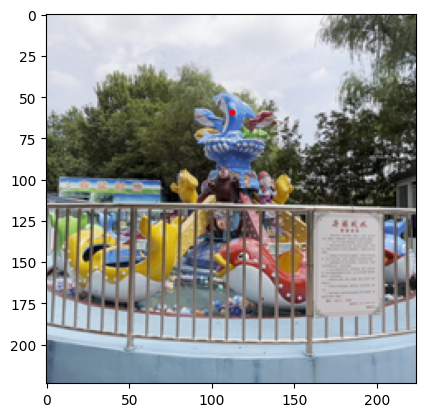

tensor([111,  14], device='cuda:6')
tensor([ 0.0010, -0.0740,  0.4032], device='cuda:6')


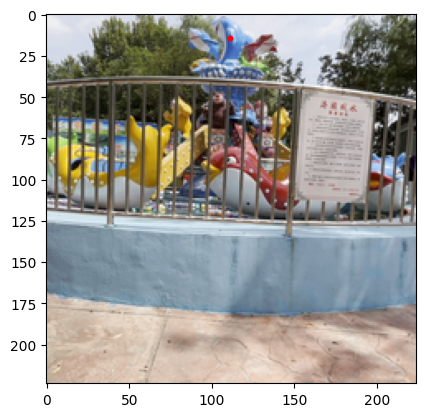

In [116]:
i = 26545
c1 = kptsA.reshape(-1,2*W*H,2)[0,i]
print(c1)
print(pred1[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(tensor_to_plot(batch[0]['img'][0], norm='dust3r'))
plt.scatter(*c1.cpu(), c='r', s=10)
plt.show()
c2 = kptsB.reshape(-1,2*W*H,2)[0,i]
print(c2)
print(pred2[0, c2[1], c2[0]]) # reverse coordinates
plt.imshow(tensor_to_plot(batch[1]['img'][0], norm='dust3r'))
plt.scatter(*c2.cpu(), c='r', s=10)
plt.show()

tensor([106, 102], device='cuda:6')
tensor([-0.0085, -0.0119,  0.3651], device='cuda:6')


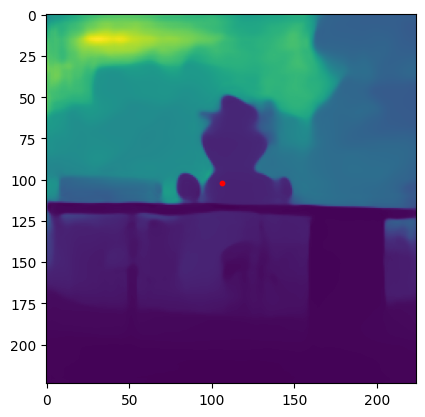

tensor([102,  57], device='cuda:6')
tensor([-0.0086, -0.0101,  0.3588], device='cuda:6')


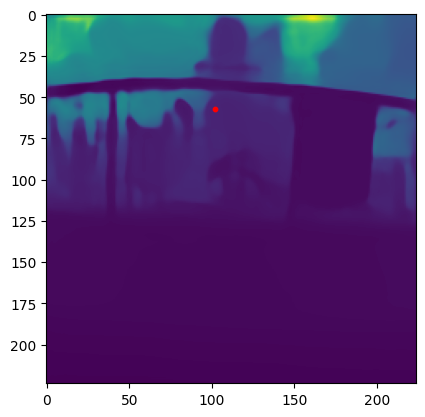

tensor([-0.0138, -0.0071,  0.3767]) tensor([-0.0463,  0.0415,  0.2738])
tensor(1.4122e-05, device='cuda:6')
tensor(0.0027, device='cuda:6')


In [154]:
i = 45802
c1 = kptsA.reshape(-1,2*W*H,2)[0,i]
print(c1)
print(pred1[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(pred1[0,...,-1].cpu())
plt.scatter(*c1.cpu(), c='r', s=10)
plt.show()
c2 = kptsB.reshape(-1,2*W*H,2)[0,i]
print(c2)
print(pred2[0, c2[1], c2[0]]) # reverse coordinates
plt.imshow(pred2[0,...,-1].cpu())
plt.scatter(*c2.cpu(), c='r', s=10)
plt.show()

print(pred1[0,*kptsA.reshape(-1,2*H*W,2)[0,i],:].cpu(), pred2[0,*kptsB.reshape(-1,2*H*W,2)[0,i],:].cpu())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]])**2).mean())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]]).abs()).mean())

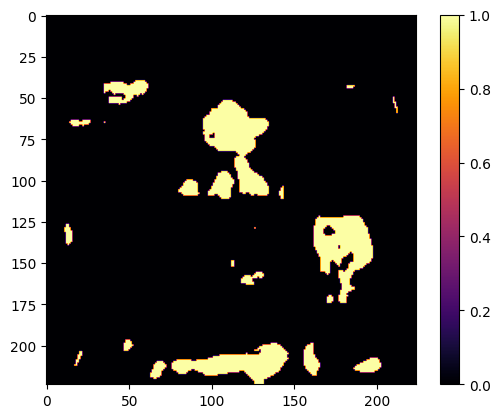

In [119]:
plt.imshow(cert.reshape(-1,H,W)[0].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

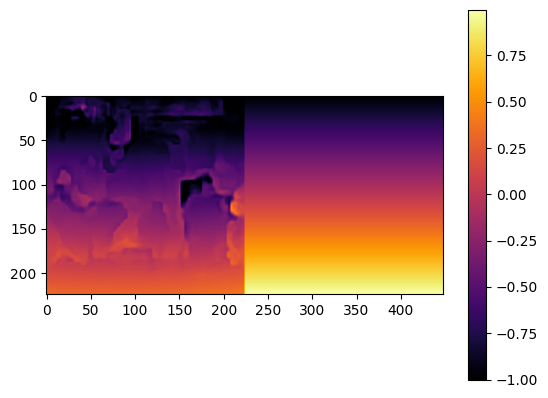

In [120]:
plt.imshow(warp.reshape(-1,H,2*W,4)[0,...,3].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

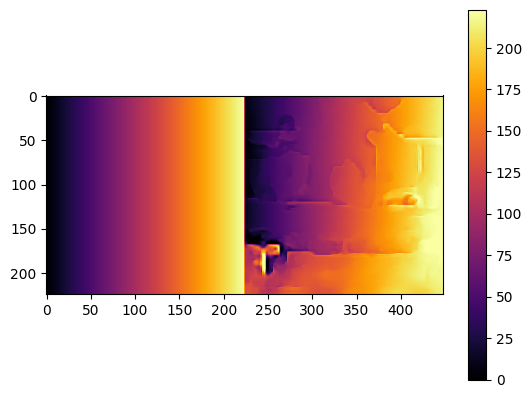

In [121]:
plt.imshow(kptsA[0,...,0].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

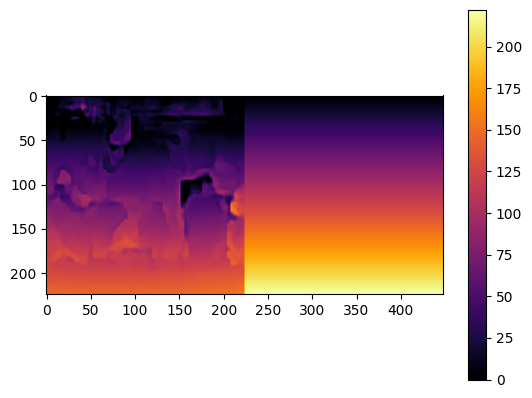

In [122]:
plt.imshow(kptsB[0,...,1].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [123]:
kpts1 = kptsA[:,:,:W,:] # B, H, W, 2
kpts2 = kptsB[:,:,:W,:] # B, H, W, 2

In [124]:
kpts1.shape

torch.Size([8, 224, 224, 2])

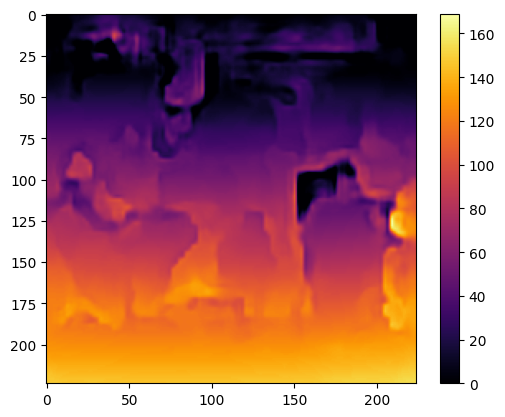

In [125]:
plt.imshow(kpts2[0,...,1].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [126]:
kpts1, kpts2 = kpts1.reshape(-1,H*W,2), kpts2.reshape(-1,H*W,2)
kpts1_flat = torch.from_numpy(np.ravel_multi_index(kpts1.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
kpts2_flat = torch.from_numpy(np.ravel_multi_index(kpts2.cpu().permute(-1,0,1).numpy(), (H, W), order='F')).to(device)
pred1_flat = pred1.reshape(-1, H*W, 3)
pred2_flat = pred2.reshape(-1, H*W, 3)

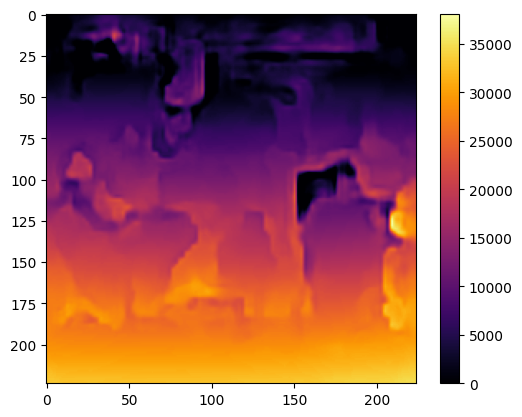

In [127]:
plt.imshow(kpts2_flat.reshape(-1,H,W)[0,...].cpu().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [128]:
kpts1_flat.shape, kpts2_flat.shape, pred1_flat.shape, pred2_flat.shape

(torch.Size([8, 50176]),
 torch.Size([8, 50176]),
 torch.Size([8, 50176, 3]),
 torch.Size([8, 50176, 3]))

In [129]:
p1 = pred1_flat.gather(1, kpts1_flat.unsqueeze(-1).expand(-1,-1,3))
p2 = pred2_flat.gather(1, kpts2_flat.unsqueeze(-1).expand(-1,-1,3))

In [130]:
p1.shape

torch.Size([8, 50176, 3])

In [131]:
((p1 - p2)**2).mean(), (p1 - p2).abs().mean()

(tensor(0.0224, device='cuda:6'), tensor(0.0573, device='cuda:6'))

In [132]:
cert = (certainty.reshape(-1,H,2*W)[:,:,:W].reshape(-1,H*W) > 0.5).float()
p1c = p1 * cert.unsqueeze(-1)
p2c = p2 * cert.unsqueeze(-1)

In [133]:
((p1c - p2c)**2).mean() / cert.mean(), (p1c - p2c).abs().mean() / cert.mean()

(tensor(0.0024, device='cuda:6'), tensor(0.0101, device='cuda:6'))

In [151]:
torch.topk(certainty[0], 100).indices

tensor([26545, 26097, 26096, 26993, 26544, 26994, 26546, 25648, 27442, 26995,
        25649, 27443, 26992, 27441, 27891, 27890, 26098, 26547, 27889, 25647,
        27892, 26095, 28339, 27444, 27440, 25200, 28338, 26543, 26996, 27888,
        28340, 26991, 28337, 28782, 29230, 28335, 29677, 27887, 28336, 29229,
        27439, 28334, 28783, 30125, 25199, 45804, 25201, 29678, 26099, 25650,
        26548, 28787, 27893, 28786, 46252, 45803, 28781, 29231, 27886, 30573,
        30126, 27445, 30124, 45355, 29676, 45356, 28784, 28341, 28785, 30572,
        28788, 26990, 26542, 25646, 27438, 26094, 31021, 46251, 29228, 28333,
        26997, 29679, 31020, 30574, 45802, 45354, 46700, 45805, 29234, 31469,
        29235, 29232, 24752, 25198,  5260, 28780, 31468, 27885, 29675, 30123],
       device='cuda:6')

tensor([106, 102], device='cuda:6')
tensor([-0.0085, -0.0119,  0.3651], device='cuda:6')


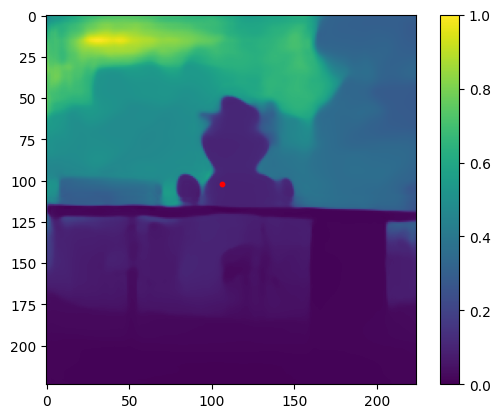

tensor([-0.0086, -0.0101,  0.3588], device='cuda:6')


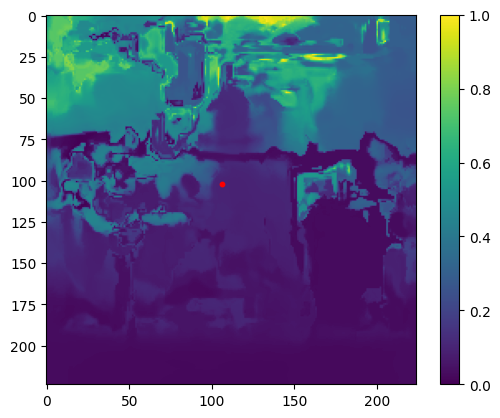

tensor([-0.0085, -0.0119,  0.3651]) tensor([ 0.0010, -0.0740,  0.4032])
tensor(0.0018, device='cuda:6')
tensor(0.0366, device='cuda:6')


In [153]:
i = 45802
c1 = kptsA.reshape(-1,2*W*H,2)[0,i]
print(c1)
print(p1.reshape(-1,H,W,3)[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(p1.reshape(-1,H,W,3)[0,:,:,-1].cpu().numpy())
plt.scatter(*c1.cpu(), c='r', s=10)
plt.colorbar()
plt.show()

print(p2.reshape(-1,H,W,3)[0, c1[1], c1[0]]) # reverse coordinates
plt.imshow(p2.reshape(-1,H,W,3)[0,:,:,-1].cpu().numpy())
plt.scatter(*c1.cpu(), c='r', s=10)
plt.colorbar()
plt.show()

print(pred1[0, c1[1], c1[0]].cpu(), pred2[0, c2[1], c2[0]].cpu())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]])**2).mean())
print(((pred1[0, c1[1], c1[0]] - pred2[0, c2[1], c2[0]]).abs()).mean())

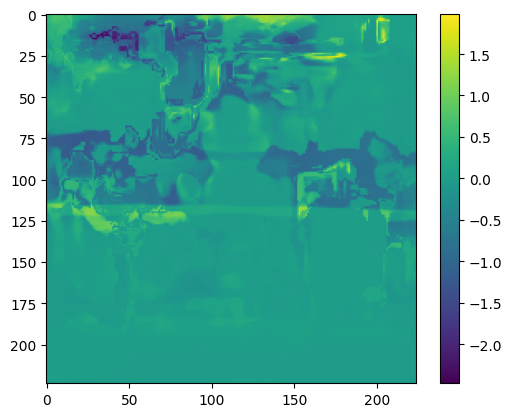

In [142]:
diff = p2 - p1
plt.imshow(diff.reshape(-1,H,W,3)[0,:,:,2].cpu().numpy())
plt.colorbar()
plt.show()

In [143]:
diff.min(), diff.max(), (diff**2).mean()

(tensor(-2.4722, device='cuda:6'),
 tensor(1.9867, device='cuda:6'),
 tensor(0.0224, device='cuda:6'))